# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [23]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [24]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [25]:
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from typing import Dict, Sequence
from datetime import datetime
import torch
from collections import deque, OrderedDict
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import vizdoom as vzd
from vizdoom import ScreenFormat

import pandas as pd

from gym import Env
from torch import nn
from einops import rearrange

from doom_arena import VizdoomMPEnv, ObsBuffer
from doom_arena.render import render_episode
from IPython.display import HTML
from typing import Dict, Tuple


In [27]:
from agents.utils import *
from agents.utils_viz import *
from agents.helpers import *
from agents.dqn import EfficientDQN, epsilon_greedy, soft_update_target_network

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [28]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["labels"],#, "automap"], #["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

EXTRA_STATE_DIMS = {key: value for key, value in {"screen": 3, "labels": 1, "depth": 1, "automap": 3}.items() if key in PLAYER_CONFIG["extra_state"] or key == "screen"}

In [38]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_PLAYERS = 2
NUM_BOTS = 1 #1, #6
EPISODE_TIMEOUT = 1500
# TODO: model hyperparams
GAMMA = 0.99
EPISODES = 2 #100
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 20_000
LEARNING_RATE = 5e-5
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995 # 0.987
N_EPOCHS = 50
TARGET_UPDATE_FREQ = 1000
FRAME_SKIPPING = 3
FRAME_SKIPPING_STOP = 100
DEBUG = True
PRINT_EVERY = 10

In [42]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

DTYPE = torch.float32

reward_fn = YourReward(num_players=NUM_PLAYERS)

env = VizdoomMPEnv(
    num_players=NUM_PLAYERS, # 4 is max
    num_bots=NUM_BOTS,
    bot_skill=2, # Increased difficulty
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    screen_format=PLAYER_CONFIG["screen_format"],
    reward_fn=reward_fn,
    seed = np.random.randint(1, 2000, NUM_PLAYERS),
    ticrate = 35*3,
)

Device: mps
Environment Seed: [ 432 1490]
Host 53193
Player 53193


## Example of environment

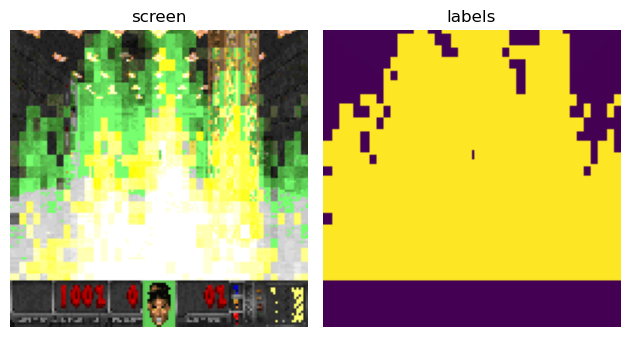

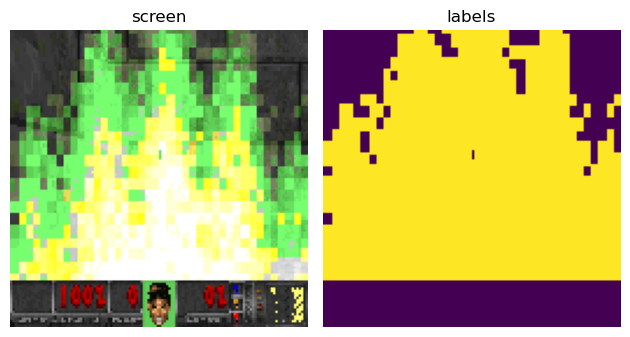

In [43]:
# Reset environment
with suppress_output():
    obs_start: torch.Tensor = env.reset()
    
for player in range(len(obs_start)):
    plot_images(obs_start[player], EXTRA_STATE_DIMS)

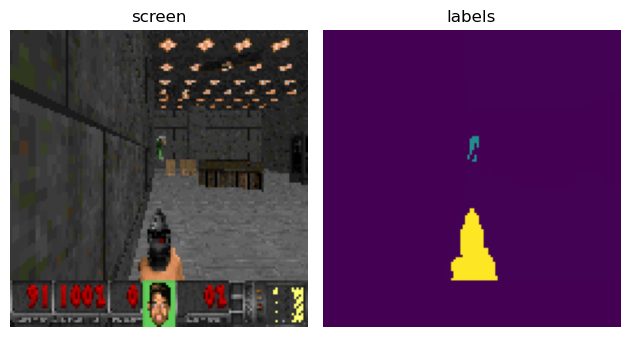

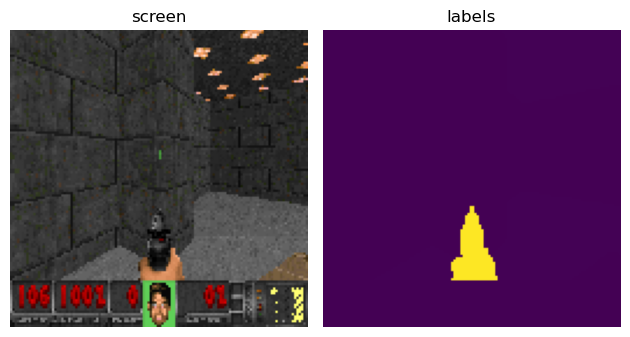

In [64]:
# Iterate 60 steps
STEPS = 60

if env.num_players > 1:
    actions = [random.randint(0, action_space.n - 1) for action_space in env.action_space] # Multiple players
else:
    actions = random.randint(0, env.action_space.n - 1) # Single players

for i in range(STEPS):
    obs_next: torch.Tensor = env.step(actions)

for player in range(env.num_players):
    plot_images(obs_next[0][player], EXTRA_STATE_DIMS)

### Example of Reward

In [33]:
player_idx = np.random.randint(0, env.num_players)
for key, value_now, value_old in zip(env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars.values(), env.envs[player_idx].unwrapped._game_vars_pre.values()):
    print(f"{key+':':<25}{value_now:.0f} | {value_old:.0f}")

HEALTH:                  100 | 100
AMMO3:                   0 | 0
FRAGCOUNT:               0 | 0
ARMOR:                   0 | 0
HITCOUNT:                0 | 0
HITS_TAKEN:              0 | 0
DEAD:                    0 | 0
DEATHCOUNT:              0 | 0
DAMAGECOUNT:             0 | 0
DAMAGE_TAKEN:            0 | 0
KILLCOUNT:               0 | 0
SELECTED_WEAPON:         2 | 2
SELECTED_WEAPON_AMMO:    110 | 110
POSITION_X:              576 | 576
POSITION_Y:              224 | 224


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [34]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================

# main Q-network
input_channels = {k: v *  N_STACK_FRAMES for k, v in EXTRA_STATE_DIMS.items()}
print(input_channels)

model = EfficientDQN(
    input_channels_dict=input_channels,
    action_space=env.action_space.n if env.num_players == 1 else env.action_space[0].n,
    feature_dim_cnns = 128,
    hidden_dim_heads = 2048,
).to(device, dtype=DTYPE)

# Load a model from file
# model = model.load_model("runs/20250620_151451/best_model_20250620_153705.pt")

{'screen': 3, 'labels': 1}
Initialized model with 2963309 parameters!


In [35]:
target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-5)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Training loop

In [36]:
# ---------------------  TRAINING LOOP  ----------------------

# Create folder for training
training_id = datetime.now().strftime("%Y%m%d_%H%M%S")
training_folder = os.path.join("runs", training_id)
os.makedirs(training_folder, exist_ok=True)

# Define logger
logger = FileLogger(training_folder, also_print=DEBUG)

In [ ]:
# Training settings
q_loss_list, epsilon_history = [], []
reward_history = {player: [] for player in range(env.num_players)}
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0

for episode in range(EPISODES):
    
    with suppress_output():
        obs: torch.Tensor = env.reset()
    
    # Episode variables for each player
    episode_metrics = {player: {"frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "health_pickup": 0} for player in range(env.num_players)}
    episode_reward = {player: 0.0 for player in range(env.num_players)}
    done = False
    model.eval()
    
    episode_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Steps done: {steps_done} | Gathering rollout (currently {len(replay_buffer)})"
    logger.log(episode_msg)
    
    # ───────── rollout ─────────────────────────────────────────────
    while not done:
        
        # Skip Frames (Testing - I am aware that in the original paper they stacked the images. I want to get many more steps at the beginning)
        act = epsilon_greedy(env, model, obs, epsilon, device, EXTRA_STATE_DIMS, DTYPE)
        
        max_skip_steps = min(FRAME_SKIPPING * (episode < FRAME_SKIPPING_STOP), 1)
        for skip_steps in range(max_skip_steps):    
            next_obs, reward, done, _ = env.step(act)
            steps_done += 1

        # ----- reward definition ----------------
        for player_idx in range(env.num_players):
            episode_reward[player_idx] += np.sum(reward[player_idx]) # Should be a list with one value
            reward_components = reward_fn(None, env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars_pre, None)

            if len(reward_components) >= 6:
                episode_metrics[player_idx]["frags"] += reward_components[0]
                episode_metrics[player_idx]["hits"] += reward_components[1]
                episode_metrics[player_idx]["damage_taken"] += reward_components[2]
                episode_metrics[player_idx]["movement"] += reward_components[3]
                episode_metrics[player_idx]["ammo_efficiency"] += reward_components[4]
                episode_metrics[player_idx]["survival"] += reward_components[5]
                episode_metrics[player_idx]["health_pickup"] += reward_components[6]
        
            # ----- buffer and environment handling ----------------
            if env.num_players == 1:
                act = [act]
                
            replay_buffer.append((obs[player_idx], act[player_idx], reward[player_idx], next_obs[player_idx], done))
        
    obs = next_obs
    [reward_history[player_idx].append(reward) for player_idx, reward in episode_reward.items()] # Append rewards for every player
    epsilon_history.append(epsilon)

    # ───────── learning step (experience replay) ──────────────────
    if len(replay_buffer) >= BATCH_SIZE:
        #print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Enriching replay buffer...") if DEBUG else None

        model.train()
        train_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs"
        logger.log(train_msg)
        
        for epoch in range(N_EPOCHS):

            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors for training
            states = process_observation(torch.stack(states), EXTRA_STATE_DIMS, device, DTYPE)
            next_states = process_observation(torch.stack(next_states), EXTRA_STATE_DIMS, device, DTYPE)
            actions = torch.tensor(actions, device=device)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32) #.squeeze(1) # Added squeeze here
            dones = torch.tensor(dones, device=device, dtype=torch.float32)

            current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Target q values
            with torch.no_grad():
                next_q = target_model(next_states).max(1)[0] #.values
                target_q = rewards + GAMMA * next_q * (1 - dones)
            
            loss = loss_fn(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            q_loss_list.append(loss.item())
        
        # Update target network        
        target_update_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network..."
        logger.log(target_update_msg)
        soft_update_target_network(model, target_model, tau=1e-3)
        #hard_update_target_network(target_model, model)
        
        # Update scheduler and epsilon
        scheduler.step()
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    else:
        train_fail_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}"
        logger.log(train_fail_msg, print_once=True)

    # -------- logging ----------
    avg_reward = get_avg_reward(reward_history, episodes=PRINT_EVERY, round=0)
    avg_loss = np.mean(q_loss_list[-10:]) if q_loss_list else 0
    stacked_episode_reward = np.array([np.round(reward, 0) for reward in episode_reward.values()])
    
    # Rewards and losses
    reward_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Rewards:\n"
    reward_msg += f"\tReward: {stacked_episode_reward} | Avg Reward: {avg_reward} | Loss: {avg_loss:.4f} | ε: {epsilon:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}"
    reward_msg += f"\n\tMetrics - {[f'{metric}: {value}' for metric, value in get_average_result(episode_metrics).items()]}"
        
    logger.log(reward_msg, print_once = episode % PRINT_EVERY == 0)
        
    # Show the video 
    if episode % PRINT_EVERY * 2 == 0:
        with suppress_output():
            replay_episode(env, target_model, device, EXTRA_STATE_DIMS, DTYPE, path=training_folder, store=True)
    
    # ───────── quick evaluation for best-model tracking ───────────
    quick_eval_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation..."
    logger.log(quick_eval_msg)

    with suppress_output():
        eval_obs = env.reset() # List of obs
        
    eval_episode_rewards = [0.0] * env.num_players
    eval_done = False
    model.eval()
 
    while not eval_done:
        eval_action_list = epsilon_greedy(env, model, eval_obs, 0, device, EXTRA_STATE_DIMS, DTYPE)
        eval_next_obs_list, eval_reward_list, eval_done, _ = env.step(eval_action_list)
        for i in range(env.num_players):
            eval_episode_rewards[i] += eval_reward_list[i]
        eval_obs = eval_next_obs_list
    
    mean_eval_reward = np.mean(eval_episode_rewards)
    
    if mean_eval_reward > best_reward:
        best_reward = mean_eval_reward
        model_name = "best_model_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".pt"
        model.save_model(path=training_folder, filename=model_name)
        best_model = deepcopy(model)

19:27:32 | Episode: 0 | Steps done: 0 | Gathering rollout (currently 0)
19:27:46 | Episode: 0 | Training for 50 epochs
19:27:51 | Episode: 0 | Updating target network...
19:27:51 | Episode: 0 | Rewards:
	Reward: [ 76. 174.  49.] | Avg Reward: 100.0 | Loss: 0.8403 | ε: 0.995 | LR: 4.98e-05
	Metrics - ['frags: 0', 'hits: 33', 'damage_taken: -6', 'movement: 23', 'ammo_efficiency: 6', 'survival: 43', 'health_pickup: 0']


SignalException: Signal SIGINT received. ViZDoom instance has been closed.

## Dump to ONNX

In [ ]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)

    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

def onnx_export_multi_buffer(env, model, config, filename: str):
    """Export multi-buffer model to ONNX format"""
    model.eval()
    
    # Create dummy inputs for all buffers
    dummy_screen = torch.randn(1, input_channels["screen"], 128, 128)
    dummy_inputs = {"screen": dummy_screen}
    
    if "depth" in input_channels:
        dummy_inputs["depth"] = torch.randn(1, input_channels["depth"], 128, 128)
    if "labels" in input_channels:
        dummy_inputs["labels"] = torch.randn(1, input_channels["labels"], 128, 128)
    if "automap" in input_channels:
        dummy_inputs["automap"] = torch.randn(1, input_channels["automap"], 128, 128)
    
    # For ONNX export, we need to handle the dictionary input differently
    # This is a simplified version - you might need to modify based on your exact requirements
    print("Note: Multi-buffer ONNX export may require custom handling.")
    print("Exporting with screen buffer only for compatibility.")
    
    # Simple export with screen buffer
    torch.onnx.export(
        model.screen_encoder.cpu(),  # Export just the screen encoder for compatibility
        dummy_screen,
        filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["screen"],
        output_names=["features"],
        dynamic_axes={"screen": {0: "batch_size"}, "features": {0: "batch_size"}},
    )
    
    # Add metadata
    onnx_model = onnx.load(filename)
    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)
    onnx.save(onnx_model, filename)
    
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best

onnx_filename = os.path.join(training_folder, "enhanced_doom_agent.onnx")
onnx_export_multi_buffer(env, final_model, PLAYER_CONFIG, onnx_filename)
print(f"Best network exported to {onnx_filename}")

Note: Multi-buffer ONNX export may require custom handling.
Exporting with screen buffer only for compatibility.


[autoreload of doom_arena.doom_env failed: Traceback (most recent call last):
  File "/Users/matsschneider/miniconda3/envs/jku_wad/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/Users/matsschneider/miniconda3/envs/jku_wad/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/matsschneider/miniconda3/envs/jku_wad/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/matsschneider/Docum

AttributeError: 'EfficientDQN' object has no attribute 'screen_encoder'

### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


In [ ]:
# ---------------------------------------------------------------
#  Reward-plot helper  (feel free to edit / extend)
# ---------------------------------------------------------------

plot_training_metrics(get_avg_reward(reward_history, episodes=0), q_loss_list, epsilon_history)


In [ ]:
replay_episode(env, final_model.cpu(), device, EXTRA_STATE_DIMS, DTYPE, store=True)